# Deep Learning Brain Segmentation

> Brain segmentation for the 2D images using convolutional neural network.

[https://github.com/zsxoff/deep-learning-brain-segmentation](https://github.com/zsxoff/deep-learning-brain-segmentation)

This segmentation using neural networks is performed on a Neurite OASIS Sample Data. 

As the authors write, *Organized data collection including 414 subjects from the open-access OASIS dataset processed with FreeSurfer and SAMSEG for the neurite package.*

Source: [https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md](https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md)

---

## Prepare project

### Import packages

In [1]:
from glob import glob

import matplotlib.pyplot as plt
import nibabel
import numpy as np
import seaborn as sns
import seaborn_image as isns
import tensorflow as tf
from sklearn.model_selection import train_test_split

from models.unet import UNet

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams["figure.dpi"] = 100

sns.set_context("paper")
sns.set_style("whitegrid")

### Check GPU

In [2]:
print(tf.config.list_physical_devices("GPU"))

!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sat Jun 26 15:50:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 21%   47C    P0    32W / 120W |    407MiB /  4035MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                     

### Fix random seed

In [3]:
SEED = 42
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

## Show random Neurite Oasis image

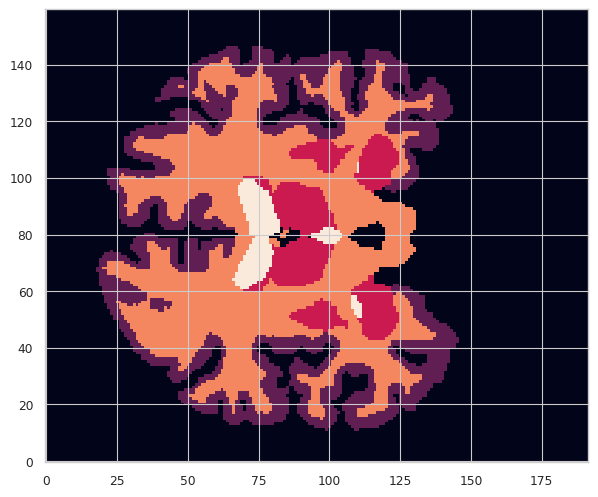

In [4]:
obj = nibabel.load("./neurite-oasis.2d.v1.0/OASIS_OAS1_0004_MR1/slice_seg4.nii.gz")

img = np.asarray(obj.dataobj)

plt.imshow(img);

## Load data

In [5]:
IMG_W = 160
IMG_H = 192

### Path to Neurite Oasis images

In [6]:
ORIG_IMAGES_PATHS = sorted(glob("./neurite-oasis.2d.v1.0/**/slice_norm.nii.gz"))

SEG4_IMAGES_PATHS, SEG24_IMAGES_PATHS = (
    sorted(glob("./neurite-oasis.2d.v1.0/**/slice_seg4.nii.gz")),
    sorted(glob("./neurite-oasis.2d.v1.0/**/slice_seg24.nii.gz")),
)

### Functions for loading data

In [7]:
def split_segmentation(seg: np.ndarray, slices: int) -> np.ndarray:

    result = np.zeros((seg.shape[0], seg.shape[1], slices)).astype(int)

    for i in range(slices):

        sliced = np.copy(seg)
        sliced[sliced != i + 1] = 0
        sliced[sliced != 0] = 1

        result[..., i] = np.copy(sliced[..., 0])

    return result


def _nii_to_numpy(fp) -> np.asarray:
    return np.asarray(nibabel.load(fp).dataobj)


def src_load(fp: str) -> np.asarray:
    return _nii_to_numpy(fp)


def dst_load(fp: str, slices: int) -> np.asarray:
    return split_segmentation(_nii_to_numpy(fp), slices)


def src_loader(files: list) -> np.asarray:
    res = np.zeros((len(files), IMG_W, IMG_H, 1))

    for k, src in enumerate(files):
        res[k, :, :, :] = src_load(src)

    return res


def dst_loader(files: list, slices: int) -> np.asarray:
    res = np.zeros((len(files), IMG_W, IMG_H, slices))

    for k, src in enumerate(files):
        res[k, :, :, :] = dst_load(src, slices)

    return res

## Initialize neural network components

### Hyperparameters

In [8]:
BATCH_SIZE = 16
LR = 0.001

### Metrics

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)

    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(tf.square(y_true), -1) + tf.reduce_sum(tf.square(y_pred), -1) + smooth
    )


def dice_coef_neg(y_true, y_pred, smooth=1):
    return 1 - dice_coef(y_true, y_pred, smooth)

### Loss

In [10]:
metric_binary_crossentropy = tf.keras.metrics.BinaryCrossentropy(
    name="binary_crossentropy", from_logits=True, label_smoothing=0
)

### Optimizer

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR, name="Adam")

### Callbacks

In [12]:
callback_save_best_weights_04 = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"weights_04", monitor=metric_binary_crossentropy, mode="min", save_best_only=True, verbose=0,
)

callback_save_best_weights_24 = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"weights_24", monitor=metric_binary_crossentropy, mode="min", save_best_only=True, verbose=0,
)

callback_csv_logger_04 = tf.keras.callbacks.CSVLogger(
    filename=f"training_log_04.csv", separator=",", append=False,
)

callback_csv_logger_24 = tf.keras.callbacks.CSVLogger(
    filename=f"training_log_24.csv", separator=",", append=False,
)

## Train neural network for 4 segments

### Load data

In [13]:
src_imgs_train, src_imgs_test, dst_imgs_train, dst_imgs_test = train_test_split(
    ORIG_IMAGES_PATHS, SEG4_IMAGES_PATHS, test_size=0.20, shuffle=True, random_state=SEED,
)

print("X Len train:", len(src_imgs_train))
print("X Len test: ", len(src_imgs_test))
print()
print("y Len train:", len(dst_imgs_train))
print("y Len test: ", len(dst_imgs_test))
print()

SLICES_COUNT = 4

X_train = src_loader(src_imgs_train)
y_train = dst_loader(dst_imgs_train, slices=SLICES_COUNT)

X_test = src_loader(src_imgs_test)
y_test = dst_loader(dst_imgs_test, slices=SLICES_COUNT)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print()
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X Len train: 331
X Len test:  83

y Len train: 331
y Len test:  83

X_train shape: (331, 160, 192, 1)
y_train shape: (331, 160, 192, 4)

X_test shape: (83, 160, 192, 1)
y_test shape: (83, 160, 192, 4)


### Train network

In [14]:
model = UNet(
    input_shape=(IMG_W, IMG_H, 1), out_channels=SLICES_COUNT, filters=[16, 32, 64, 128, 256]
)

model.compile(optimizer=optimizer, loss=tf.keras.metrics.binary_crossentropy, metrics=[dice_coef])

history = model.fit(
    X_train,
    y_train,
    validation_split=0.33,
    epochs=110,
    batch_size=BATCH_SIZE,
    callbacks=[
        callback_csv_logger_04,
        # callback_save_best_weights_04,
    ],
    verbose=0,
)

model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 192, 1)]     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
u_net_conv_down (UNetConvDow multiple                  985648    
_________________________________________________________________
u_net_conv_down_1 (UNetConvD multiple                  505664    
_________________________________________________________________
u_net_conv_down_2 (UNetConvD multiple                  301696    
_________________________________________________________________
u_net_conv_down_3 (UNetConvD multiple                  345344    
_________________________________________________________________
u_net_conv_down_4 (UNetConvD multiple                  948736

### Plot history

In [15]:
hist_epochs = history.epoch

hist_loss = history.history["loss"]
hist_dice_coef = history.history["dice_coef"]

hist_val_loss = history.history["val_loss"]
hist_val_dice_coef = history.history["val_dice_coef"]

#### Train history

##### Loss function

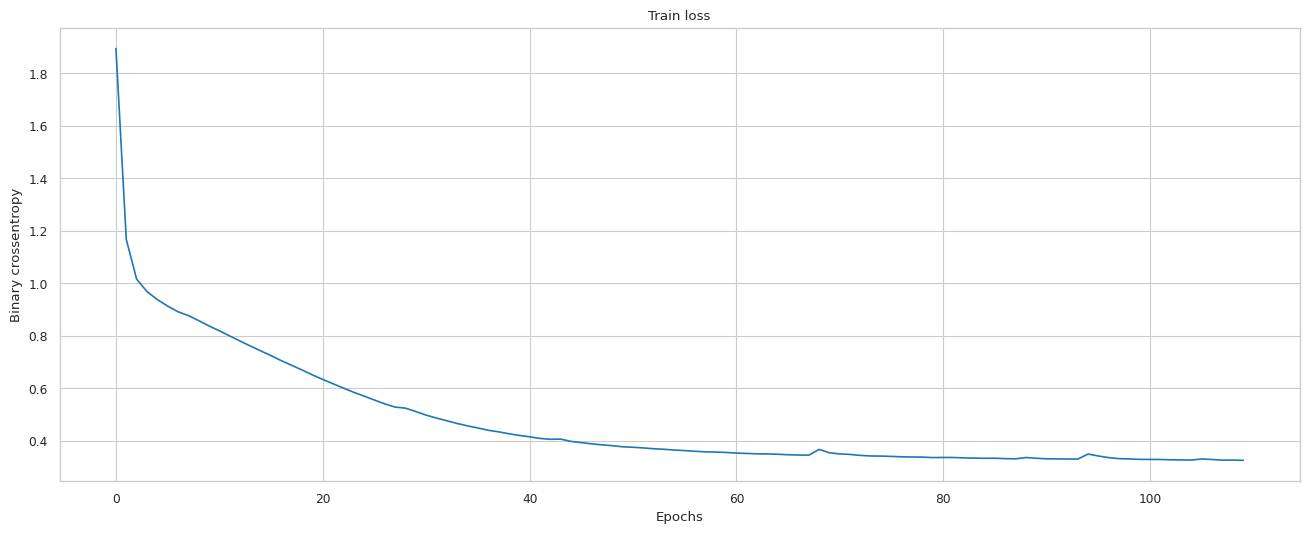

In [16]:
plt.plot(hist_epochs, hist_loss)
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Binary crossentropy")
plt.show()

##### Metrics

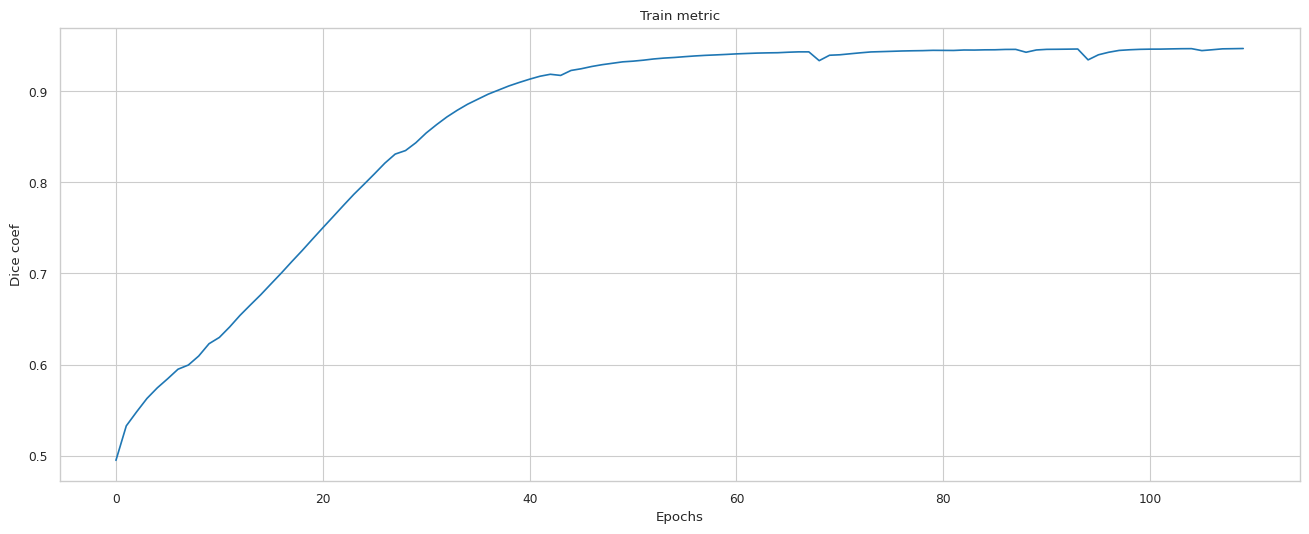

In [17]:
plt.plot(hist_epochs, hist_dice_coef)
plt.title("Train metric")
plt.xlabel("Epochs")
plt.ylabel("Dice coef")
plt.show()

#### Validation history

##### Loss function

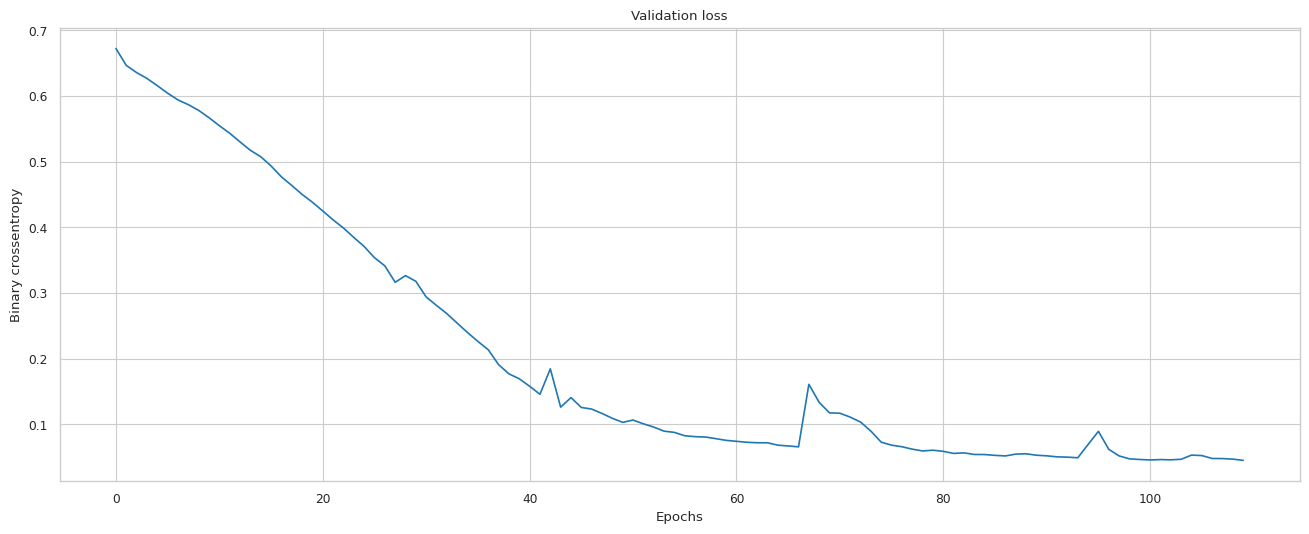

In [18]:
plt.plot(hist_epochs, hist_val_loss)
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Binary crossentropy")
plt.show()

##### Metrics

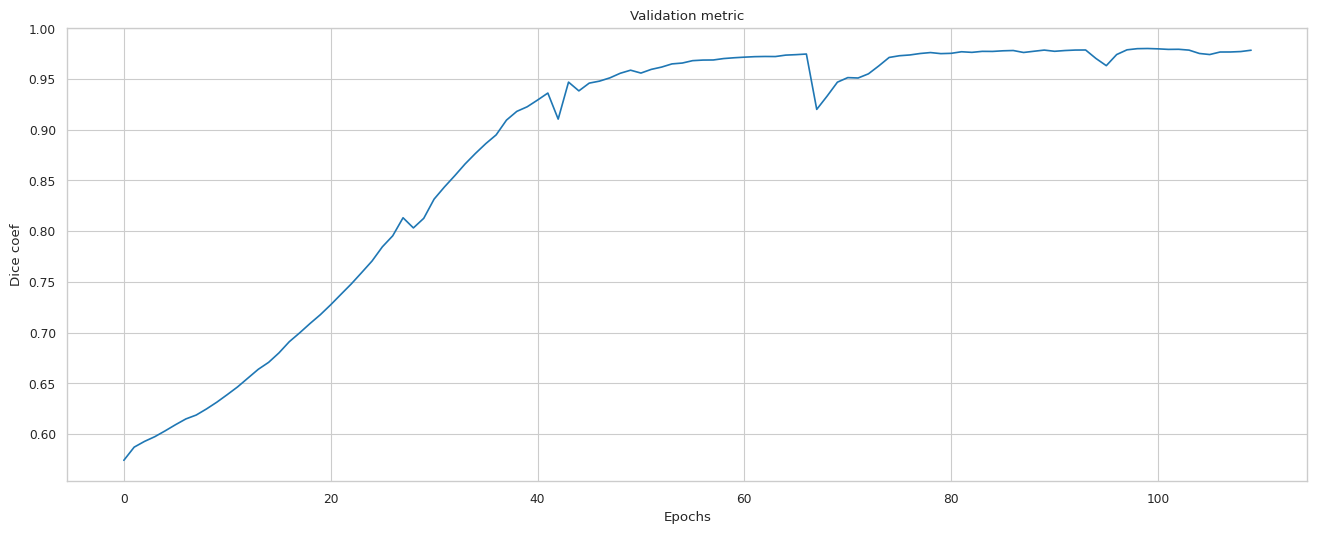

In [19]:
plt.plot(hist_epochs, hist_val_dice_coef)
plt.title("Validation metric")
plt.xlabel("Epochs")
plt.ylabel("Dice coef")
plt.show()

### Get prediction on test

In [20]:
res = model.predict(X_test)

### Plot predicted images

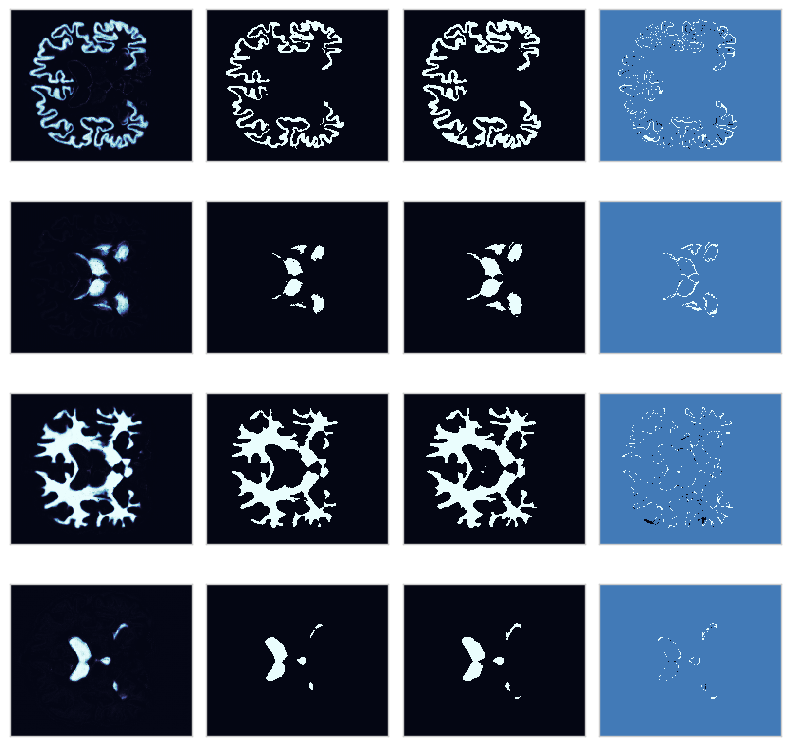

In [21]:
visualize = []

for i in range(SLICES_COUNT):
    # Predicted channel.
    img_1 = res[0][:, :, i]

    # Predicted channel - binarized.
    img_2 = np.copy(res[0][:, :, i])
    img_2[img_2 >= 0.5] = 1
    img_2[img_2 < 0.5] = 0

    # Original image channel.
    img_3 = y_test[0][:, :, i]

    img_4 = img_3 - img_2

    visualize.append(img_1)
    visualize.append(img_2)
    visualize.append(img_3)
    visualize.append(img_4)

g = isns.ImageGrid(visualize, cbar=False, height=2, col_wrap=4, step=1, cmap="ice")

## Train neural network for 24 segments

### Load data

In [22]:
src_imgs_train, src_imgs_test, dst_imgs_train, dst_imgs_test = train_test_split(
    ORIG_IMAGES_PATHS, SEG24_IMAGES_PATHS, test_size=0.20, shuffle=True, random_state=SEED,
)

print("X Len train:", len(src_imgs_train))
print("X Len test: ", len(src_imgs_test))
print()
print("y Len train:", len(dst_imgs_train))
print("y Len test: ", len(dst_imgs_test))
print()

SLICES_COUNT = 24

X_train = src_loader(src_imgs_train)
y_train = dst_loader(dst_imgs_train, slices=SLICES_COUNT)

X_test = src_loader(src_imgs_test)
y_test = dst_loader(dst_imgs_test, slices=SLICES_COUNT)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print()
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X Len train: 331
X Len test:  83

y Len train: 331
y Len test:  83

X_train shape: (331, 160, 192, 1)
y_train shape: (331, 160, 192, 24)

X_test shape: (83, 160, 192, 1)
y_test shape: (83, 160, 192, 24)


### Train network

In [23]:
model = UNet(
    input_shape=(IMG_W, IMG_H, 1), out_channels=SLICES_COUNT, filters=[16, 32, 64, 128, 256]
)

model.compile(optimizer=optimizer, loss=tf.keras.metrics.binary_crossentropy, metrics=[dice_coef])

history = model.fit(
    X_train,
    y_train,
    validation_split=0.33,
    epochs=110,
    batch_size=BATCH_SIZE,
    callbacks=[
        callback_csv_logger_24,
        # callback_save_best_weights_24,
    ],
    verbose=0,
)

model.summary()

Model: "u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 192, 1)]     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
u_net_conv_down_5 (UNetConvD multiple                  985648    
_________________________________________________________________
u_net_conv_down_6 (UNetConvD multiple                  505664    
_________________________________________________________________
u_net_conv_down_7 (UNetConvD multiple                  301696    
_________________________________________________________________
u_net_conv_down_8 (UNetConvD multiple                  345344    
_________________________________________________________________
u_net_conv_down_9 (UNetConvD multiple                  9487

### Plot history

In [24]:
hist_epochs = history.epoch

hist_loss = history.history["loss"]
hist_dice_coef = history.history["dice_coef"]

hist_val_loss = history.history["val_loss"]
hist_val_dice_coef = history.history["val_dice_coef"]

#### Train history

##### Loss function

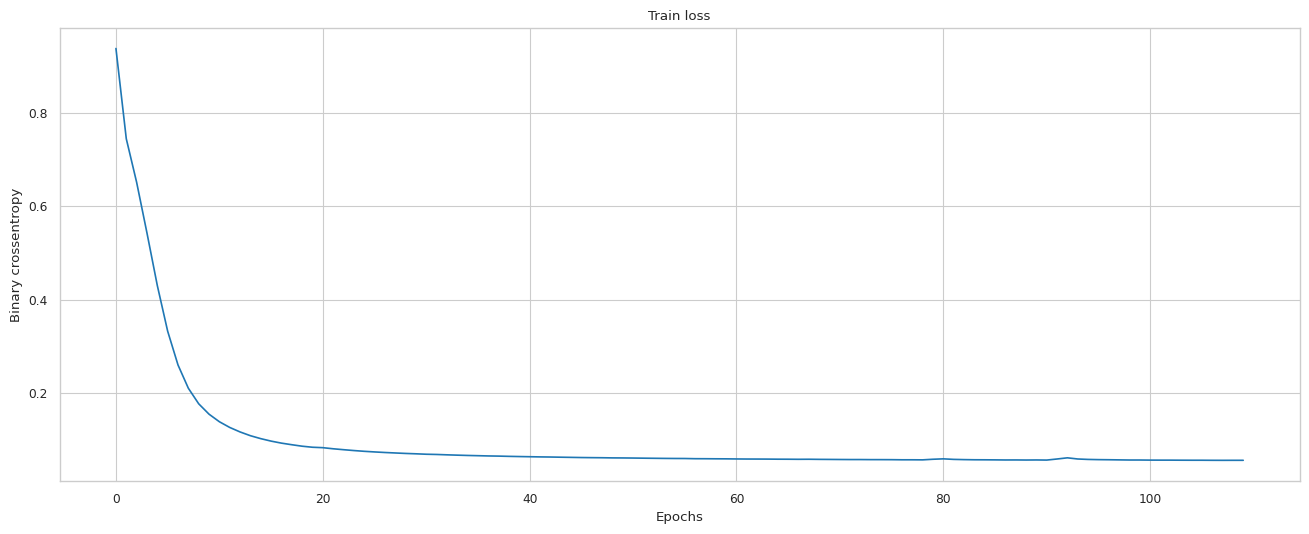

In [25]:
plt.plot(hist_epochs, hist_loss)
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Binary crossentropy")
plt.show()

##### Metrics

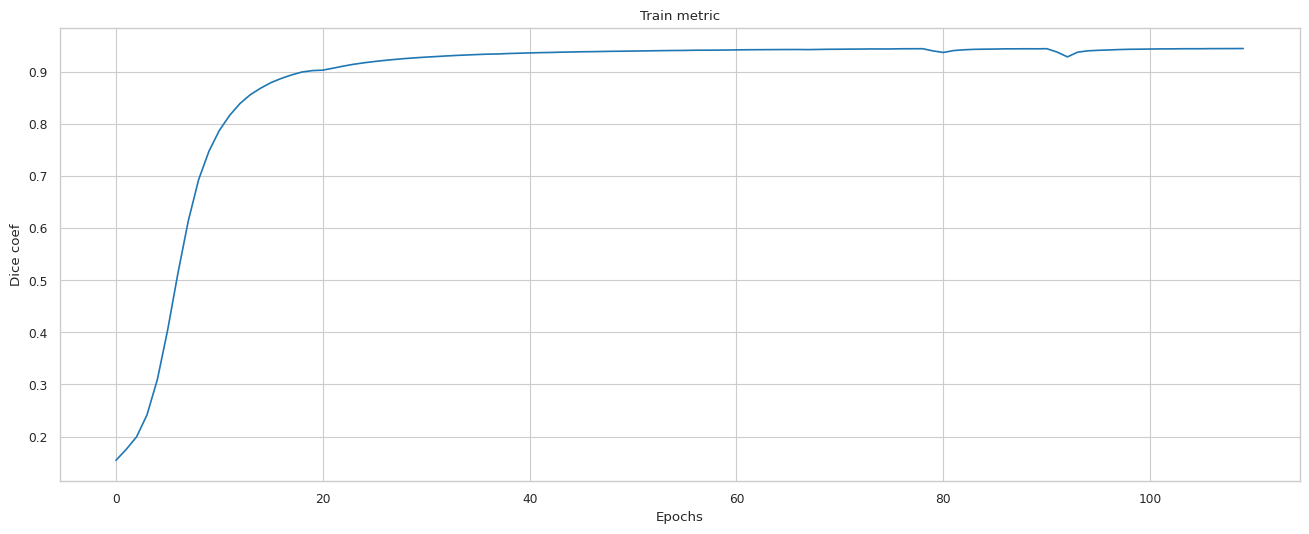

In [26]:
plt.plot(hist_epochs, hist_dice_coef)
plt.title("Train metric")
plt.xlabel("Epochs")
plt.ylabel("Dice coef")
plt.show()

#### Validation history

##### Loss function

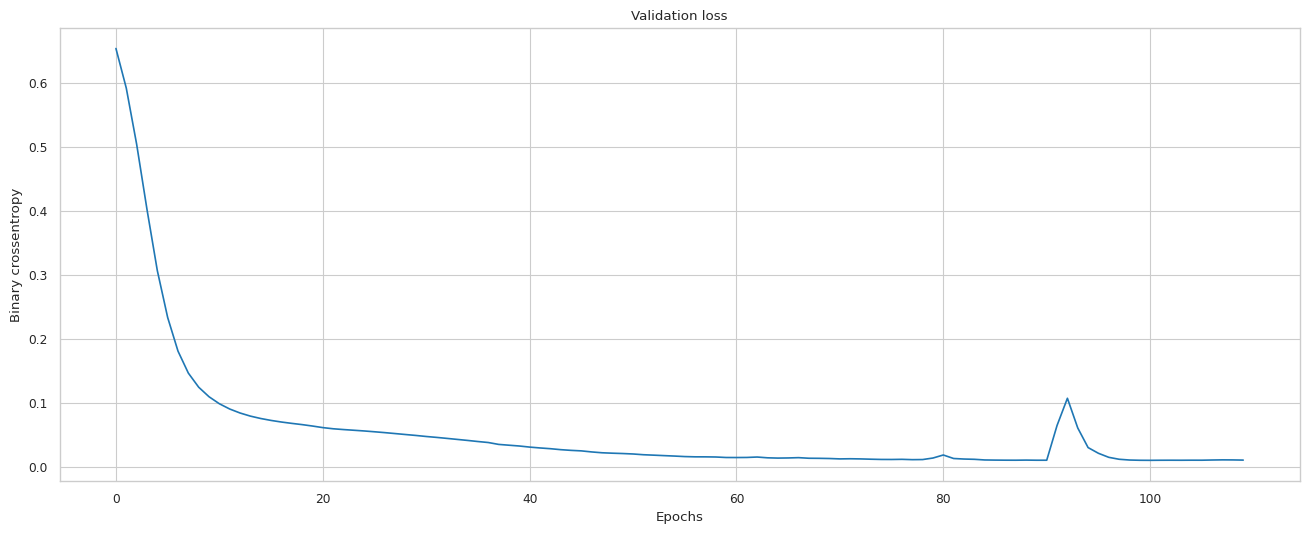

In [27]:
plt.plot(hist_epochs, hist_val_loss)
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Binary crossentropy")
plt.show()

##### Metrics

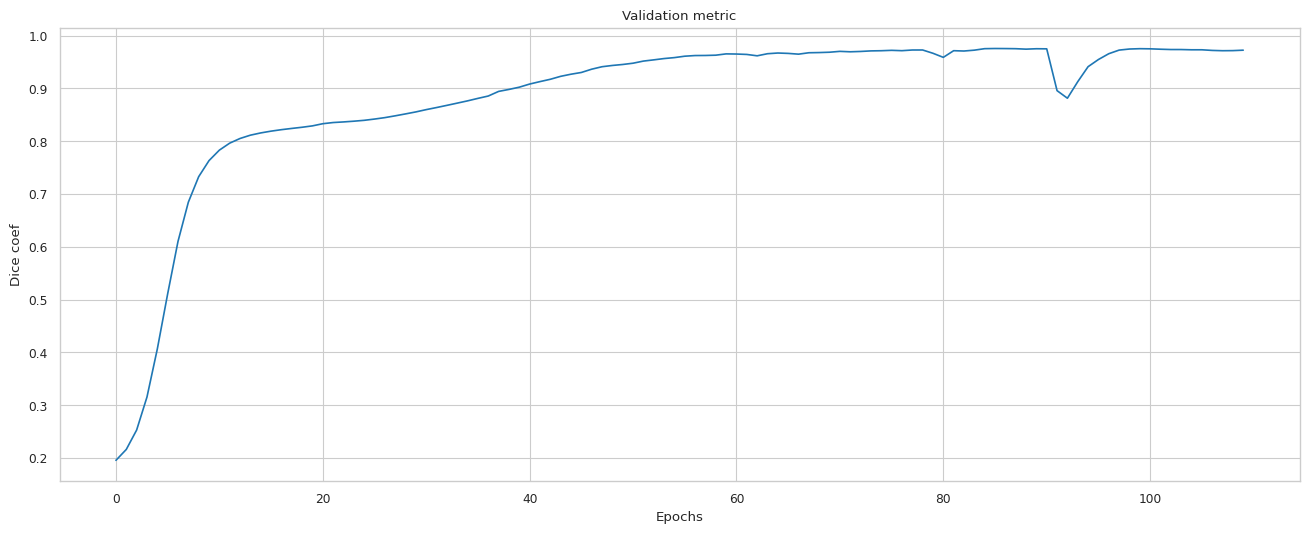

In [28]:
plt.plot(hist_epochs, hist_val_dice_coef)
plt.title("Validation metric")
plt.xlabel("Epochs")
plt.ylabel("Dice coef")
plt.show()

### Get prediction on test

In [29]:
res = model.predict(X_test)

### Plot predicted images

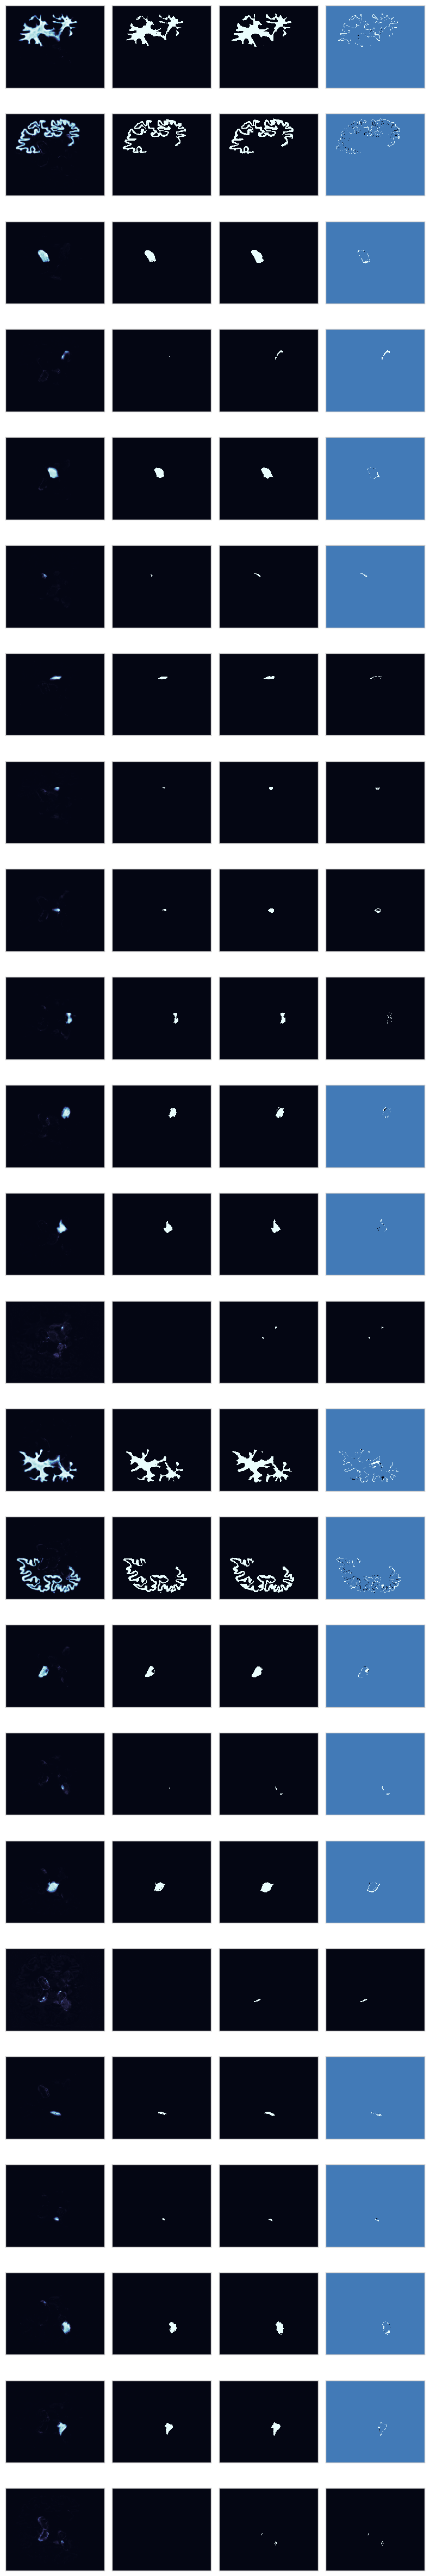

In [30]:
visualize = []

for i in range(SLICES_COUNT):
    # Predicted channel.
    img_1 = res[0][:, :, i]

    # Predicted channel - binarized.
    img_2 = np.copy(res[0][:, :, i])
    img_2[img_2 >= 0.5] = 1
    img_2[img_2 < 0.5] = 0

    # Original image channel.
    img_3 = y_test[0][:, :, i]

    img_4 = img_3 - img_2

    visualize.append(img_1)
    visualize.append(img_2)
    visualize.append(img_3)
    visualize.append(img_4)


g = isns.ImageGrid(visualize, cbar=False, height=2, col_wrap=4, step=1, cmap="ice")